In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [21]:
ev_path = 'Resources/Clean_EV_Data.csv'
ev_df = pd.read_csv(ev_path)
# ev_df.head()
census_path = 'Resources/2022_census'
cen_df = pd.read_csv(census_path)

In [22]:
# merge census and EV data in order to compute regression and relationships
cen_df = cen_df.rename(columns={'WA Zipcode':'Postal Code'})
ev_cen = cen_df.merge(ev_df, on='Postal Code').reset_index()
# clean dataframe to include only the columns we are working with
clean_merged_df = ev_cen[['Census Year',
                          'Postal Code',
                          'Population',
                          'Median Household Income',
                          'Income Per Capita',
#                           'County',
                          'Make',
                          'Model',
                          'Electric Vehicle Type']]
clean_merged_df

,Census Year,Postal Code,Population,Median Household Income,Income Per Capita,Make,Model,Electric Vehicle Type
0,2022,98901,33106,55536,25237.0,NISSAN,LEAF,Battery Electric Vehicle (BEV)
1,2022,98901,33106,55536,25237.0,TESLA,MODEL 3,Battery Electric Vehicle (BEV)
2,2022,98901,33106,55536,25237.0,VOLKSWAGEN,ID.4,Battery Electric Vehicle (BEV)
3,2022,98901,33106,55536,25237.0,TESLA,MODEL 3,Battery Electric Vehicle (BEV)
4,2022,98901,33106,55536,25237.0,MERCEDES-BENZ,B-CLASS,Battery Electric Vehicle (BEV)
...,...,...,...,...,...,...,...,...
112241,2022,99131,122,34081,31798.0,NISSAN,LEAF,Battery Electric Vehicle (BEV)
112242,2022,99348,1590,74211,32056.0,CHEVROLET,VOLT,Plug-in Hybrid Electric Vehicle (PHEV)
112243,2022,98336,594,76250,30549.0,HONDA,CLARITY,Plug-in Hybrid Electric Vehicle (PHEV)
112244,2022,98935,4378,60085,18814.0,TESLA,MODEL 3,Battery Electric Vehicle (BEV)


In [23]:
ev_count = clean_merged_df.groupby('Postal Code').count()
type_count = ev_count[['Electric Vehicle Type']]
type_count = type_count.reset_index()

In [24]:
df = clean_merged_df[['Postal Code','Population']]
df_per_cap = df.drop_duplicates()

In [25]:
merged_percapita = pd.merge(df_per_cap, type_count, on='Postal Code', how='outer')
merged_percapita

,Postal Code,Population,Electric Vehicle Type
0,98901,33106,69
1,98237,4979,21
2,98201,30587,250
3,98021,34993,1156
4,98203,36448,344
...,...,...,...
491,99131,122,1
492,99348,1590,1
493,98336,594,1
494,98935,4378,1


In [26]:
merged_percapita['EV Population Percent'] = (merged_percapita['Electric Vehicle Type']/merged_percapita['Population'])*100
merged_percapita = merged_percapita.rename(columns = {'Electric Vehicle Type':'Electric Vehicle Count'})

In [27]:
merged_percapita.sort_values(by='EV Population Percent', ascending=False)

,Postal Code,Population,Electric Vehicle Count,EV Population Percent
344,98134,852,158,18.544601
451,98833,153,14,9.150327
153,98039,2923,242,8.279165
441,98286,158,11,6.962025
124,98072,25034,1661,6.634976
...,...,...,...,...
492,99348,1590,1,0.062893
437,98952,1724,1,0.058005
411,98857,3545,2,0.056417
403,98951,13145,5,0.038037


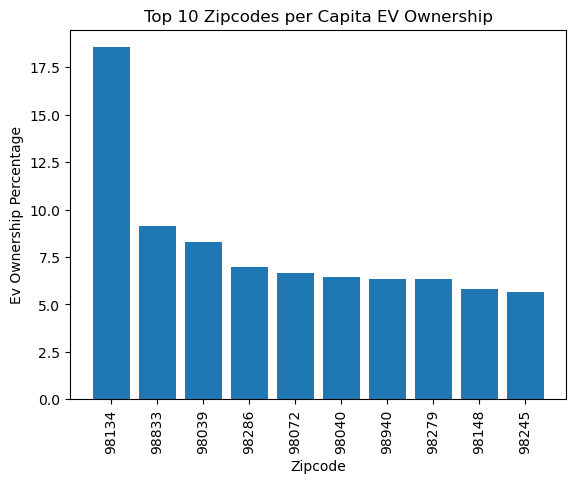

In [28]:
#graph top ten zip codes 
merged_percapita_top10 = merged_percapita.nlargest(10,columns='EV Population Percent')

x_axis_list = np.arange(len(merged_percapita_top10['Postal Code']))
x_ticks = [value for value in x_axis_list]
y_axis = merged_percapita_top10['EV Population Percent']
plt.title('Top 10 Zipcodes per Capita EV Ownership')
plt.xlabel('Zipcode')
plt.ylabel('Ev Ownership Percentage')
plt.xticks(x_ticks, merged_percapita_top10['Postal Code'], rotation='vertical')
plt.bar(x_axis_list, y_axis)
plt.savefig('Graphs/top10-EVownership')
plt.show()

In [29]:
clean_ev_cen = ev_cen.groupby('Make').agg({'Income Per Capita':['median','mean'],
                           'Postal Code':lambda x: x.nunique()}).reset_index()
clean_ev_cen.columns = clean_ev_cen.columns.map('_'.join)
print(clean_ev_cen.shape)
clean_ev_cen_filtered = clean_ev_cen[clean_ev_cen['Postal Code_<lambda>']>10]
#                                      np.nanquantile(clean_ev_cen['Postal Code_<lambda>'],0.025)]
print(clean_ev_cen_filtered.shape)
# clean_ev_cen_filtered.sort_values('Income Per Capita_median')

(34, 4)
(31, 4)


In [30]:
ev_sum = clean_ev_cen_filtered['Postal Code_<lambda>'].sum()
clean_ev_cen_filtered['Make Percent'] = (clean_ev_cen_filtered['Postal Code_<lambda>']/ev_sum)*100
clean_ev_cen_filtered = clean_ev_cen_filtered.sort_values(by='Make Percent')
clean_ev_cen_filtered.head()

/var/folders/q0/1ctrg7ln7537xxm0j8j094dm0000gn/T/ipykernel_1048/1721433677.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_ev_cen_filtered['Make Percent'] = (clean_ev_cen_filtered['Postal Code_<lambda>']/ev_sum)*100


,Make_,Income Per Capita_median,Income Per Capita_mean,Postal Code_<lambda>,Make Percent
10,GENESIS,62999.0,63760.611111,15,0.230097
8,FISKER,52800.0,61512.736842,18,0.276116
17,LEXUS,56311.0,64853.969697,28,0.429514
16,LAND ROVER,75493.5,72068.052632,32,0.490873
28,SUBARU,60001.0,61104.016949,46,0.705630


In [31]:
type_slp, type_int, type_r, type_p, type_stderr = stats.linregress(clean_ev_cen_filtered['Income Per Capita_median'],
                                                                  clean_ev_cen_filtered['Make Percent'])

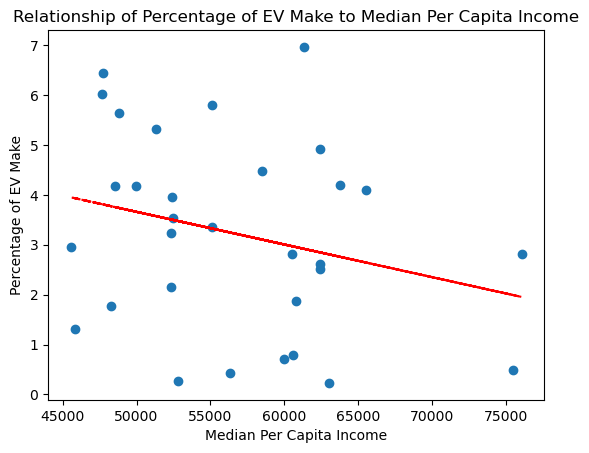

In [32]:
plt.scatter(clean_ev_cen_filtered['Income Per Capita_median'], clean_ev_cen_filtered['Make Percent'])
type_line = type_slp * clean_ev_cen_filtered['Income Per Capita_median'] + type_int
plt.plot(clean_ev_cen_filtered['Income Per Capita_median'],type_line,'--',color='r')
plt.title('Relationship of Percentage of EV Make to Median Per Capita Income')
plt.ylabel('Percentage of EV Make')
plt.xlabel('Median Per Capita Income')
plt.savefig('Graphs/EV-make-pc-Income-line')


In [33]:
clean_ev_cen_filtered = clean_ev_cen_filtered.sort_values(by='Income Per Capita_median')


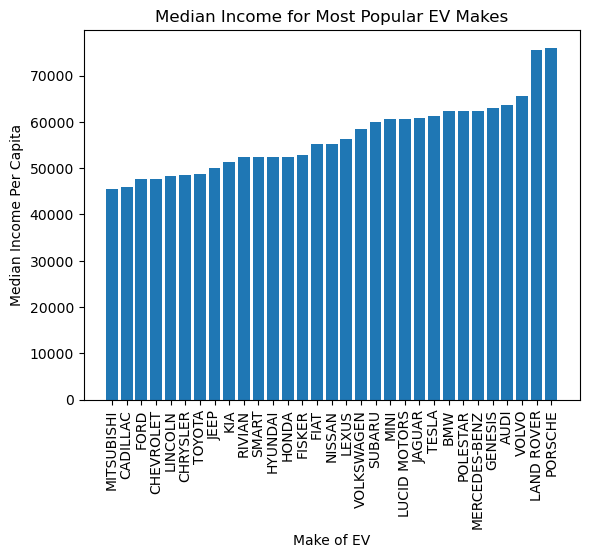

In [34]:

x_axis_list = np.arange(len(clean_ev_cen_filtered['Make_']))
x_ticks = [value for value in x_axis_list]
plt.title('Median Income for Most Popular EV Makes')
plt.xlabel('Make of EV')
plt.ylabel('Median Income Per Capita')
plt.xticks(x_ticks, clean_ev_cen_filtered['Make_'], rotation='vertical')
plt.bar(clean_ev_cen_filtered['Make_'], clean_ev_cen_filtered['Income Per Capita_median'])
plt.savefig('Graphs/income_make_bar')

In [35]:
clean_type_ev_cen = ev_cen.groupby(['Make','Electric Vehicle Type']).agg({'Income Per Capita':['median','mean'],
                           'Postal Code':lambda x: x.nunique()}).reset_index()
clean_type_ev_cen.columns = clean_type_ev_cen.columns.map('_'.join)
print(clean_ev_cen.shape)
clean_type_ev_cen_filtered = clean_type_ev_cen[clean_type_ev_cen['Postal Code_<lambda>']>50]
#                                      np.nanquantile(clean_ev_cen['Postal Code_<lambda>'],0.025)]
print(clean_type_ev_cen_filtered.shape)
clean_type_ev_cen_filtered
clean_type_ev_cen_filtered

(34, 4)
(38, 5)


,Make_,Electric Vehicle Type_,Income Per Capita_median,Income Per Capita_mean,Postal Code_<lambda>
0,AUDI,Battery Electric Vehicle (BEV),63748.0,69694.487979,224
1,AUDI,Plug-in Hybrid Electric Vehicle (PHEV),63748.0,69177.295681,233
4,BMW,Battery Electric Vehicle (BEV),67017.0,70668.909091,182
5,BMW,Plug-in Hybrid Electric Vehicle (PHEV),61597.0,66961.024993,314
6,CADILLAC,Plug-in Hybrid Electric Vehicle (PHEV),45845.5,52690.898148,85
7,CHEVROLET,Battery Electric Vehicle (BEV),50946.0,56513.980099,373
8,CHEVROLET,Plug-in Hybrid Electric Vehicle (PHEV),46719.0,53021.017846,383
9,CHRYSLER,Plug-in Hybrid Electric Vehicle (PHEV),48511.0,56453.499156,272
10,FIAT,Battery Electric Vehicle (BEV),55109.0,60309.051157,219
12,FORD,Battery Electric Vehicle (BEV),50901.0,56194.751848,315


In [37]:
# plot box and whisker plot
# set x axis equal to the type of EV
# the boxes will include all of the makes
# set the y axis equal to the income per capita
bev = clean_type_ev_cen_filtered.loc[
    clean_type_ev_cen_filtered['Electric Vehicle Type_']=='Battery Electric Vehicle (BEV)',:]
phev = clean_type_ev_cen_filtered.loc[
    clean_type_ev_cen_filtered['Electric Vehicle Type_']=='Plug-in Hybrid Electric Vehicle (PHEV)',:]

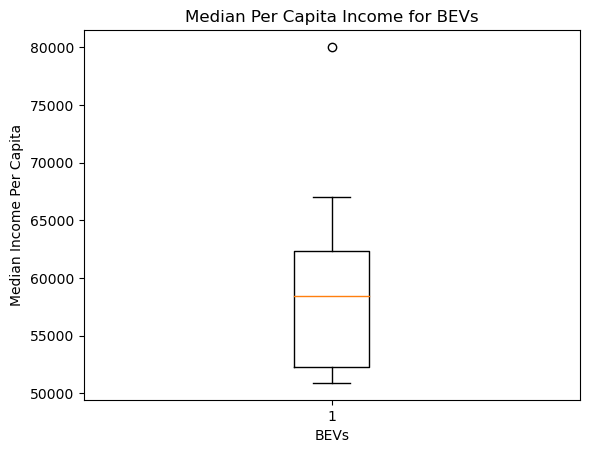

In [48]:
fig1, ax1 = plt.subplots()
ax1.boxplot(bev['Income Per Capita_median'])
ax1.set_title('Median Per Capita Income for BEVs')
ax1.set_ylabel('Median Income Per Capita')
ax1.set_xlabel('BEVs')
plt.savefig('Graphs/BEV-box')
plt.show()

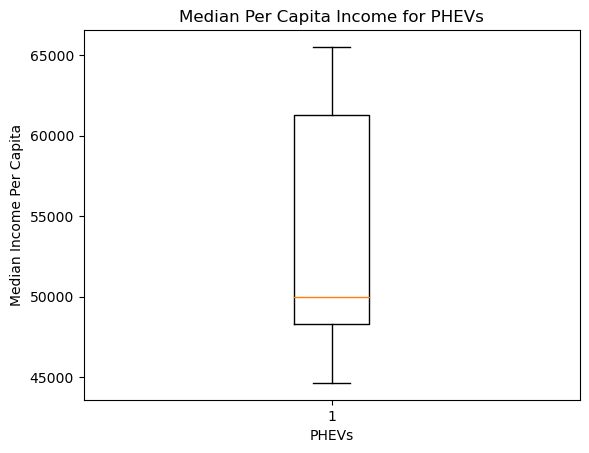

In [49]:
fig2, ax2 = plt.subplots()
ax2.boxplot(phev['Income Per Capita_median'])
ax2.set_title('Median Per Capita Income for PHEVs')
ax2.set_ylabel('Median Income Per Capita')
ax2.set_xlabel('PHEVs')
plt.savefig('Graphs/PHEV-box')
plt.show()